# EDA 3: Looking at categorical entropy

In [1]:
from itertools import product
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Shannon's informational entropy:

$E = -\sum P_i \cdot log_2(P_i)$

Consider the probability as the ratio of POIs in a region with a given category

In [2]:
from Models.utils import readTrainingData, readPoiCoos

def readCategoryData(categoryFile):
    print('Reading Categories data...')
    categoryData = open(categoryFile, 'r').readlines()
    poiToCategories = defaultdict(list)
    categoryToPois = defaultdict(list)
    for dataInstance in categoryData:
        lid, cid = dataInstance.strip().split()
        lid, cid = int(lid), int(cid)
        poiToCategories[lid].append(cid)
        categoryToPois[cid].append(lid)
    return poiToCategories, categoryToPois

poi_coos = readPoiCoos('../Data/Yelp/poiCoos.txt')
training_matrix, user_checkins, poi_checkins = readTrainingData('../Data/Yelp/train.txt', 7135, 16621, True)
ptc_map, ctp_map = readCategoryData('../Data/Yelp/poiCategories.txt')

Reading PoI coordinates...
Reading training data...
Setting threshold to median repeating POI ratio of 0.7
Setting threshold to 80th prc. of POI visits of 66.0
Reading Categories data...


## Adaptive KDE for the bandwidth

Try and use an AKDE assuming a theoretical user that visits each place once

In [6]:
len(poi_coos)

16621

In [3]:
poi_geomap = [x for k, x in poi_coos.items()]
poi_geomap_sample = pd.DataFrame([poi_geomap[i] for i in np.random.randint(0, len(poi_geomap), size=5000)], columns=['lat', 'long'])
df_poi_coos = pd.DataFrame(poi_geomap, columns=['lat', 'long'])

<Axes: xlabel='lat', ylabel='long'>

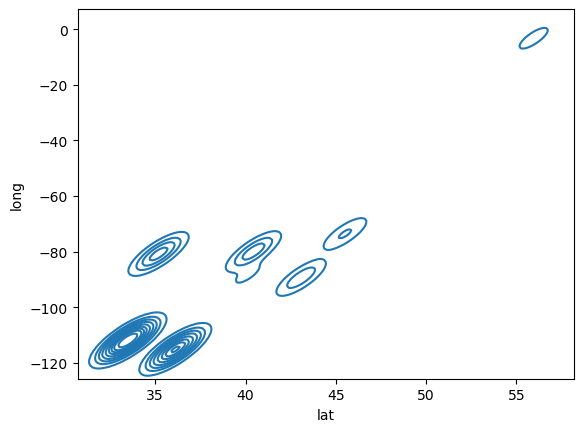

In [4]:
sns.kdeplot(data=df_poi_coos, x='lat', y='long')

**Step 1: Pilot estimation**

In [16]:
allCoos = np.array(poi_geomap)
allCoos.shape

(16621, 2)

In [17]:
N = len(poi_geomap)

meanCoo = np.sum(allCoos, axis=0) / N
meanCoo

array([  35.83211027, -104.66264229])

In [20]:
meanCooSqDiff = np.sum((allCoos - meanCoo[np.newaxis, :])**2, axis=0) / N

H1, H2 = 1.06 / (allCoos.shape[0]**0.2) * np.sqrt(meanCooSqDiff)

(H1, H2)

(0.556254462568815, 2.6556067543644835)

**Step 2: Local bandwidth**

In [45]:
def global_log_gaussian_kernel(poiCoo):
    """
    Using logarithmic kernel for numerical stability
    """
    x, y= meanCoo
    xi, yi = poiCoo
    term1 = np.log(1 / (2 * np.pi * H1 * H2))
    term2 = -1 * (
        (((x - xi)**2) / (2 * H1**2))
        + (((y - yi)**2) / (2 * H2**2))
    )
    return term1 + term2

In [50]:
logglobalKDE = np.array([global_log_gaussian_kernel(x) for x in allCoos])
print(f"{(logglobalKDE == 0).sum()} zeroes")
logglobalKDE.shape

0 zeroes


(16621,)

In [52]:
alpha = 0.5
log_g = logglobalKDE.sum() / N

log_h = -alpha * (logglobalKDE - log_g)
log_h.shape

(16621,)

In [53]:
localBandwidths = np.exp(log_h)

In [55]:
localBandwidths[0]

15448127.36747531

That didn't work...

## Using cluster centroids as means for the AKDE

In [9]:
allCoos = np.array(poi_geomap)
N = len(poi_geomap)
allCoos.shape

(16621, 2)

In [ ]:
from sklearn.cluster import KMeans

clustering = KMeans(n_clusters=8)
poiClusters = clustering.fit_predict(allCoos)

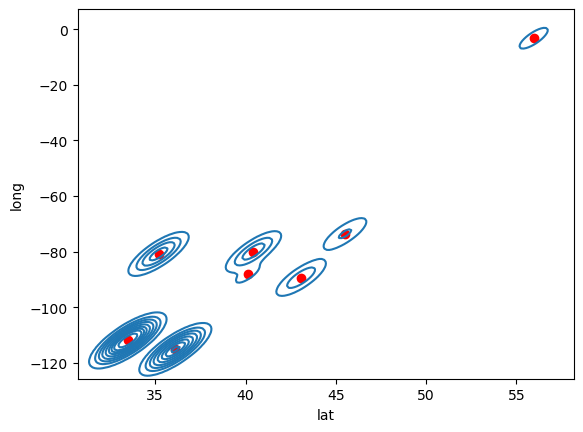

In [11]:
centroids = clustering.cluster_centers_
ax = sns.kdeplot(data=df_poi_coos, x='lat', y='long')
ax.scatter(centroids[:, 0], centroids[:, 1], color='red')

In [12]:
clusterCoos = np.array([centroids[i] for i in poiClusters])
clusterCoos.shape

(16621, 2)

In [13]:
clusterCoos

array([[  40.44104051,  -79.96709483],
       [  40.44104051,  -79.96709483],
       [  40.44104051,  -79.96709483],
       ...,
       [  36.11516756, -115.1771937 ],
       [  33.48534909, -111.98244275],
       [  35.1871628 ,  -80.83126494]])

**Step 1: Pilot estimation**

In [118]:
meanCooSqDiff = np.sum((allCoos - clusterCoos)**2, axis=0) / N

H1, H2 = 1.06 / (allCoos.shape[0]**0.2) * np.sqrt(meanCooSqDiff)

(H1, H2)

(0.014628287974094885, 0.017604364951875954)

**Step 2: Local bandwidth**

In [119]:
def global_log_gaussian_kernel(clusterCoo, poiCoo):
    """
    Using logarithmic kernel for numerical stability
    """
    x, y= clusterCoo
    xi, yi = poiCoo
    term1 = np.log(1 / (2 * np.pi * H1 * H2))
    term2 = -1 * (
        (((x - xi)**2) / (2 * H1**2))
        + (((y - yi)**2) / (2 * H2**2))
    )
    return term1 + term2

def global_gaussian_kernel(clusterCoo, poiCoo):
    x, y= clusterCoo
    xi, yi = poiCoo
    exp = np.exp(-1 * (
        (((x - xi)**2) / (2 * H1**2))
        + (((y - yi)**2) / (2 * H2**2))
    ))
    return exp / (2 * np.pi * H1 * H2)

In [120]:
logglobalKDE = np.array([global_log_gaussian_kernel(clusterCoos[i], allCoos[i]) for i in range(N)])
print(f"{(logglobalKDE == 0).sum()} zeroes")
logglobalKDE.shape

0 zeroes


(16621,)

In [121]:
alpha = 0.5
log_g = logglobalKDE.sum() / N

log_h = -alpha * (logglobalKDE - log_g)
log_h.shape

(16621,)

In [127]:
log_h

array([-8.64208126e+00, -9.19643919e+00, -1.83337804e+01, ...,
       -1.71994179e+01,  1.06747354e+02, -8.96728059e-02])

In [122]:
localBandwidths = np.exp(log_h)

/tmp/ipykernel_17024/438596018.py:1: RuntimeWarning: overflow encountered in exp
  localBandwidths = np.exp(log_h)


In [124]:
localBandwidths

array([1.76519137e-04, 1.01399825e-04, 1.09078798e-08, ...,
       3.39146807e-08, 2.28974230e+46, 9.14230267e-01])

In [81]:
allCoos[-2]

array([  33.2351099, -111.7206235])

I don't know anymore.

In [98]:
localBandwidths[2]

1.3610565566235948e-09

In [102]:
1 < 6 <= 5

False

In [130]:
def pois_within_std(poiCoo, allCoos, stdCoos, n=2):
    x_std, y_std = stdCoos
    x_i, y_i = poiCoo
    x_min, y_min = x_i - x_std*n, y_i - y_std*n
    x_max, y_max = x_i + x_std*n, y_i + y_std*n
    res = {}
    for ndx, (x, y) in enumerate(allCoos):
        if (x_min <= x <= x_max) and (y_min <= y <= y_max):
            res[ndx] = (x, y)
    return res

In [112]:
H1 * localBandwidths[-2]

2592896.7988655292

In [109]:
_test = pois_within_std(allCoos[-2], allCoos, (H1 * localBandwidths[-2], H2 * localBandwidths[-2]))
len(_test)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Fucking pain....

## Use bandwidths computed for each cluster

In [14]:
_bandwidths = []

for i in range(8): # per cluster
    poiClusterCoos = allCoos[poiClusters == i]
    centroidCoos = centroids[i]
    meanCooSqDiff = np.sum((poiClusterCoos - centroidCoos[np.newaxis, :])**2, axis=0) / poiClusterCoos.shape[0]
    Hx, Hy = 1.06 / (poiClusterCoos.shape[0]**0.2) * np.sqrt(meanCooSqDiff)
    _bandwidths.append((Hx, Hy))

bandwidths = np.array(_bandwidths)

In [15]:
bandwidths

array([[0.02212745, 0.02709466],
       [0.00610265, 0.01088361],
       [0.00259885, 0.00702722],
       [0.01230473, 0.01439051],
       [0.00884579, 0.0188884 ],
       [0.01932367, 0.01493846],
       [0.00557389, 0.01162135],
       [0.00318676, 0.00531902]])

In [16]:
def pois_within_std(poiCoo, allCoos, stdCoos, n=2):
    x_std, y_std = stdCoos
    x_i, y_i = poiCoo
    x_min, y_min = x_i - x_std*n, y_i - y_std*n
    x_max, y_max = x_i + x_std*n, y_i + y_std*n
    res = {}
    for ndx, (x, y) in enumerate(allCoos):
        if (x_min <= x <= x_max) and (y_min <= y <= y_max):
            res[ndx] = (x, y)
    return res

In [17]:
poiId = 1
_test = pois_within_std(allCoos[poiId], allCoos, bandwidths[poiClusters[poiId]], n=0.5)
print(len(_test))
_test

5


{1: (40.4081422, -80.0851737),
 13250: (40.4080431671, -80.0873225927),
 13260: (40.4098243713, -80.0853347778),
 14747: (40.407761, -80.086108),
 16553: (40.409746, -80.083623)}

## Computing categorical entropy

In [21]:
from collections import Counter

In [22]:
Counter(ptc_map[626])

Counter({2: 1, 3: 1})

In [23]:
np.log2(8)

3.0

In [35]:
def categorical_entropy(poiId, n=0.5):
    # 1. get POIs of interest
    poiCoo = allCoos[poiId]
    neighborhood = pois_within_std(poiCoo, allCoos, bandwidths[poiClusters[poiId]], n)
    # print(f"Neighborhood: {str(neighborhood)}")

    # 2. get categories
    catCounts = Counter([c for p in neighborhood.keys() for c in ptc_map[p]])
    n = len(neighborhood)
    entropy = -1 * np.sum([(count / n) * np.log2(count / n) for _, count in catCounts.items()])
    return entropy

In [36]:
categorical_entropy(1)

2.7863137138648346

In [ ]:
poi_cat_entrop